# Predicting political intentions in Tweets of politicians

## Setup and imports

In [1]:
!pip3 install ipy_table

  Created wheel for ipy-table: filename=ipy_table-1.15.1-cp36-none-any.whl size=18765 sha256=00b9ebae9f8fa5176f840c760575e419b5544ab08f0588fef25e65c6ddb53a15
  Stored in directory: /root/.cache/pip/wheels/03/89/01/203b61b7dbeb396ead2459258138e92d9cc1b8a1cc90bf570d
Successfully built ipy-table


In [2]:
from google.colab import drive
drive.mount('/content/drive')

root_folder = '/content/drive/My Drive/Projects/2017/Political Tweets'


import sys
sys.path.append(root_folder)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%tensorflow_version 1.x 

import os.path
import numpy
import pandas
import gensim
import pickle
import datetime
from gensim.models import Word2Vec
from keras.models import Model
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Embedding, Dropout, Input, merge, Lambda
from keras.callbacks import History
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.preprocessing.text import one_hot
import keras.backend as K
from collections import Counter
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from nltk.tokenize.casual import casual_tokenize

from matplotlib import pyplot
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
rcParams.update({'font.size': 24})

from sklearn.metrics import confusion_matrix
from twitterlib.classifiers.confusion_matrix import plot_confusion_matrix
from twitterlib.classifiers.unshorten import unshorten_in_text, unshorten_in_texts

from IPython.display import clear_output
from tqdm.auto import tqdm as ProgressBar
from ipy_table import make_table, set_row_style

from keras.regularizers import l2

Using TensorFlow backend.


A simple check to see if my GPU is detected, using tensorflow on the CPU for training the models freezes my laptop and makes it rather unuseable until finished.

In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16894470681852687590, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8250272349440349909
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 9667267408185195352
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14912199066
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12440125252058168024
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

# Data

Read the data and sort by timestamp. This way the last $n$ samples of the data are not in the same time-period as the other samples (although close together in time). Therefore, when a split into train and test data is made without (re)shuffling, the test data is of a different time period and the reported score is less prone to overfitting on topics of certain periods.

In [0]:
if os.path.exists(f'{root_folder}/data/codes_cara.p3'):
    with open(f'{root_folder}/data/codes_cara.p3', 'rb') as f:
        data = pickle.load(f)
else:
    data = pandas.read_csv(f'{root_folder}/data/codes_cara.csv')
    data = data.sort_values('timestamp')
    data['unshortened_message'] = list(unshorten_in_texts(ProgressBar(data['message'])))
    with open(f'{root_folder}/data/codes_cara.p3', 'wb') as f:
        pickle.dump(data, f)

Creating a matrix $X$ of `# samples` $\times$ `maximum message length in tokens` with a numeric encoding of the words. $y$ contains a vector of the labels for each sample for the specified columns 

In [6]:
column = 'T2'
filtered = data[data[column] == data[column]]

tokenized_char = filtered['unshortened_message'].tolist()
chartoken_to_index = {t:i for i,t in enumerate({token for sentence in tokenized_char for token in sentence})}
X_char = pad_sequences([[chartoken_to_index[token] for token in sentence] for sentence in tokenized_char])

tokenized = list(map(casual_tokenize, filtered['unshortened_message']))
token_to_index = {t:i for i,t in enumerate({token for sentence in tokenized for token in sentence})}
X_word = pad_sequences([[token_to_index[token] for token in sentence] for sentence in tokenized])

user_to_index = {user: index for index, user in enumerate(filtered['user'].unique())}
X_user = numpy.array([user_to_index[row['user']] for _, row in filtered.iterrows()], dtype=numpy.uint32)

y = filtered[column].as_matrix() - 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


Random shuffling and then splitting suggests to allow for overfitting on temporal topics as oposed to taking a the test set as the last several (time-)contiguous tweets, even though practice shows that it does not seem to matter.

In [0]:
n_test = 1000
(   X_char_train, X_char_test,
    X_word_train, X_word_test,
    X_user_train, X_user_test,
    y_train, y_test) = (
    X_char[:-n_test], X_char[-n_test:],
    X_word[:-n_test], X_word[-n_test:],
    X_user[:-n_test], X_user[-n_test:],
    y[:-n_test], y[-n_test:])

# (   X_char_train, X_char_test,
#     X_word_train, X_word_test,
#     X_user_train, X_user_test,
#     y_train, y_test) = train_test_split(X_char, X_word, X_user, y)

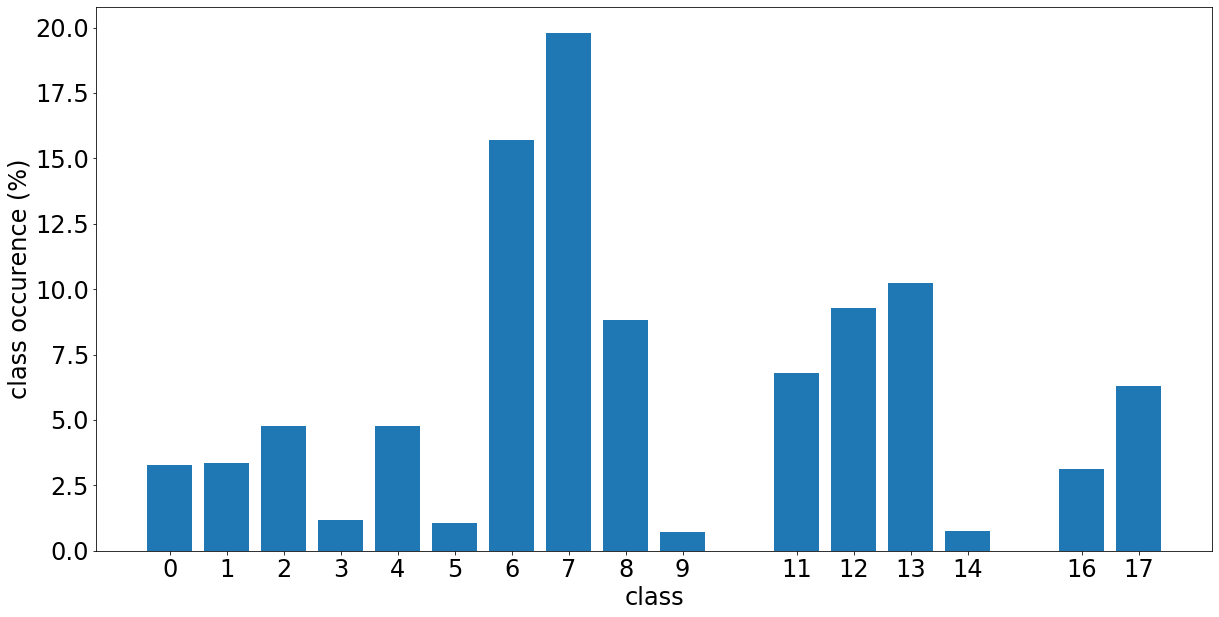

In [44]:
x, counts = map(numpy.array, zip(*Counter(y).items()))

pyplot.bar(x, 100 * counts / counts.sum())
pyplot.xticks(sorted(set(x)))
pyplot.ylabel('class occurence (%)')
pyplot.xlabel('class')
None

# Model

The model combines convolutional character and word features, and features like the twitter user. The word and user features seem to have little impact on performance, and the word features also easily overfit.

Untimately an ensemble of $10$ models, averiging the softmax output, is used to boost performance from $42$-$48\%$ to $49\%$ accuracy.

In [0]:
def lstm_model(input_length, max_index,
               embedding_vector_length, lstm_size,
               n_filters, filter_size,
               dropout_p,
               name):
    input = Input(name="{}_input".format(name), shape=(input_length, ))
    embedding = Embedding(
        max_index, embedding_vector_length, input_length=input_length,
        name='{}_embedding'.format(name))(input)
    convolution = Conv1D(
        nb_filter=n_filters,
        filter_length=filter_size,
        border_mode='same',
        activation='relu',
#         kernel_regularizer=l2(0.001),
        name='{}_convolution1'.format(name))(embedding)
#     pool = MaxPooling1D(pool_length=2, name='{}_pool1'.format(name))(convolution)
    convolution = Conv1D(
        nb_filter=n_filters,
        filter_length=filter_size,
        border_mode='same',
        activation='relu',
#         kernel_regularizer=l2(0.001),
        name='{}_convolution2'.format(name))(convolution)
#     pool = MaxPooling1D(pool_length=2, name='{}_pool2'.format(name))(convolution)
    lstm = LSTM(lstm_size, name='{}_lstm'.format(name))(convolution)
    dropout = Dropout(dropout_p, name="{}_dropout".format(name))(lstm)
    return (input, dropout)

In [0]:
def build_model():
    global X_char, X_word, y
    char_input, char_lstm = lstm_model(
        X_char.shape[1], X_char.max()+1,
        12, 256,
        32, 5,
        0.5,
        'char')
    char_output = Dense(y.max() + 1, activation='softmax', name='char_dense')(char_lstm)

    
    # Word feature parameters are set to ridiculously low values as they tend to overfit quite a lot
    # Training can go to >80% accuracy while testing stays at ~30%.
#     word_input, word_lstm = lstm_model(
#         X_word.shape[1], X_word.max()+1,
#         1, 1,
#         1, 1,
#         0.5,
#         'word')
#     word_output = Dense(y.max() + 1, activation='softmax', name='word_dense')(word_lstm)
#     output = word_output

#     user_input = Input(shape=(1,), dtype='uint8')
#     user_one_hot = Lambda(K.one_hot,
#                           arguments={'nb_classes': X_user.max() + 1},
#                           output_shape=(X_user.max() + 1,))(user_input)
#     user_output = Dense(y.max() + 1, activation='softmax', name='user_dense')(word_lstm)

#     output = merge([char_output, word_output, user_output], mode='ave')
    output = char_output

#     model = Model(input=[char_input, word_input, user_input], output=output)
    model = Model(input=[char_input], output=output)

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Training one model

We use the last $1000$ samples for training

In [11]:
model = build_model()
history = model.fit(
    [X_char_train],
#         [X_char_train, X_word_train, X_user_train],
    y_train,
    nb_epoch=30, batch_size=256,
    validation_data=([X_char_test], y_test),
#         validation_data=([X_char_test, X_word_test, X_user_test], y_test),
    verbose=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", name="char_convolution1", filters=32, kernel_size=5, padding="same")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", name="char_convolution2", filters=32, kernel_size=5, padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("ch...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 4978 samples, validate on 1000 samples
Epoch 1/30
4978/4978 [==============================] - 7s 1ms/step - loss: 2.7261 - acc: 0.1611 - val_loss: 2.4121 - val_acc: 0.2140
Epoch 2/30
4978/4978 [==============================] - 5s 1ms/step - loss: 2.4913 - acc: 0.1880 - val_loss: 2.4133 - val_acc: 0.1530
Epoch 3/30
4978/4978 [==============================] - 5s 1ms/step - loss: 2.4411 - acc: 0.2071 - val_loss: 2.3691 - val_acc: 0.1570
Epoch 4/30
4978/4978 [==============================] - 5s 1ms/step - loss: 2.3894 - acc: 0.2350 - val_loss: 2.3185 - val_acc: 0.2190
Epoch 5/30
4978/4978 [==============================] - 5s 1ms/step - loss: 2.3169 - acc: 0.2628 - val_loss: 2.2476 - val_acc: 0.2400
Epoch 6/30
4978/4978 [==============================] - 5s 1ms/step - loss: 2.2722 - acc: 0.2714 - val_loss: 2.2278 - val_acc: 0.2680
Epoch 7/30
4978/4978 [==============================] - 5s 1ms/step - loss: 2.1869 - acc: 0.3180 - val_loss: 2.1067 - val_acc: 0.3320
Epoch 8/30
497

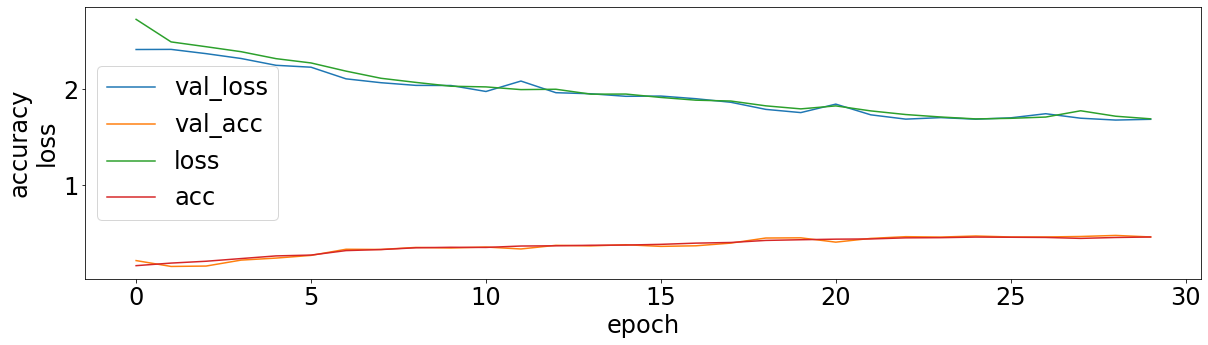

In [17]:
pyplot.figure(figsize=(20, 5))

for metric, hist in history.history.items():
  pyplot.plot(hist, label=metric)
pyplot.legend()
pyplot.xlabel('epoch')
pyplot.ylabel('accuracy\nloss')
None

# Training ensemble model

In [19]:
try:
    len(models), len(histories)
except:
    print('Resetting models and histories')
    models = []
    histories = []


for _ in ProgressBar(range(len(histories), 10)):
    print("Started training model at ", datetime.datetime.now())
    model = build_model()
    history = model.fit(
        [X_char_train],
#         [X_char_train, X_word_train, X_user_train],
        y_train,
        nb_epoch=30, batch_size=512,
        validation_data=([X_char_test], y_test),
#         validation_data=([X_char_test, X_word_test, X_user_test], y_test),
        verbose=0)
    models.append(model)
    histories.append(history)

Started training model at  2020-01-21 17:19:52.364981


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", name="char_convolution1", filters=32, kernel_size=5, padding="same")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", name="char_convolution2", filters=32, kernel_size=5, padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("ch...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Started training model at  2020-01-21 17:21:14.124948


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", name="char_convolution1", filters=32, kernel_size=5, padding="same")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", name="char_convolution2", filters=32, kernel_size=5, padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("ch...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Started training model at  2020-01-21 17:22:35.604883


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", name="char_convolution1", filters=32, kernel_size=5, padding="same")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", name="char_convolution2", filters=32, kernel_size=5, padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("ch...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Started training model at  2020-01-21 17:23:56.930456


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", name="char_convolution1", filters=32, kernel_size=5, padding="same")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", name="char_convolution2", filters=32, kernel_size=5, padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("ch...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Started training model at  2020-01-21 17:25:18.051056


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", name="char_convolution1", filters=32, kernel_size=5, padding="same")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", name="char_convolution2", filters=32, kernel_size=5, padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("ch...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Started training model at  2020-01-21 17:26:41.095389


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", name="char_convolution1", filters=32, kernel_size=5, padding="same")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", name="char_convolution2", filters=32, kernel_size=5, padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("ch...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Started training model at  2020-01-21 17:28:03.353341


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", name="char_convolution1", filters=32, kernel_size=5, padding="same")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", name="char_convolution2", filters=32, kernel_size=5, padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("ch...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Started training model at  2020-01-21 17:29:25.826811


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", name="char_convolution1", filters=32, kernel_size=5, padding="same")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", name="char_convolution2", filters=32, kernel_size=5, padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("ch...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Started training model at  2020-01-21 17:30:49.277480


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", name="char_convolution1", filters=32, kernel_size=5, padding="same")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", name="char_convolution2", filters=32, kernel_size=5, padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("ch...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


In [20]:
train_performance_per_model = numpy.array([
#     model.evaluate([X_char_train, X_word_train, X_user_train], y_train, verbose=0)
    model.evaluate([X_char_train], y_train, verbose=0)
    for model in ProgressBar(models)
])

In [0]:
class AverageEnsemble():
    def __init__(self, models):
        self.models = models
    def predict(self, *args, **kwargs):
        r = self.models[0].predict(*args, **kwargs)
        for model in self.models[1:]:
            r += model.predict(*args, **kwargs)
        return r / len(self.models)

In [0]:
# Ensemble model of the three with best insample performance.
ensemble_model = AverageEnsemble([models[i] for i in train_performance_per_model[:,1].argsort()[-3:]])

# Learning curves

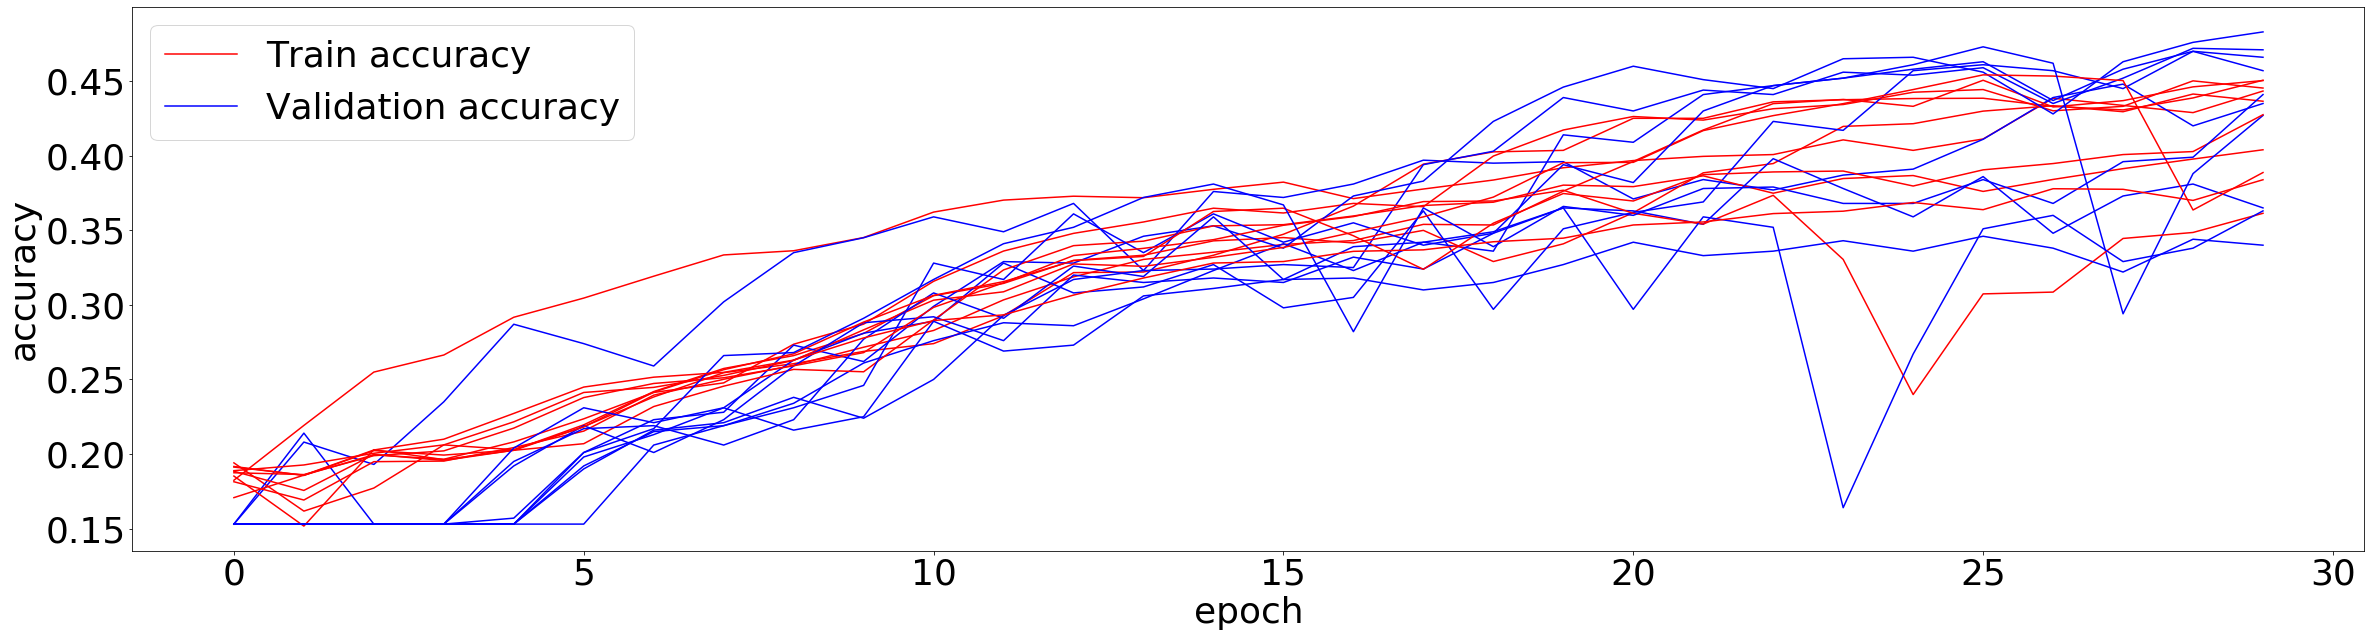

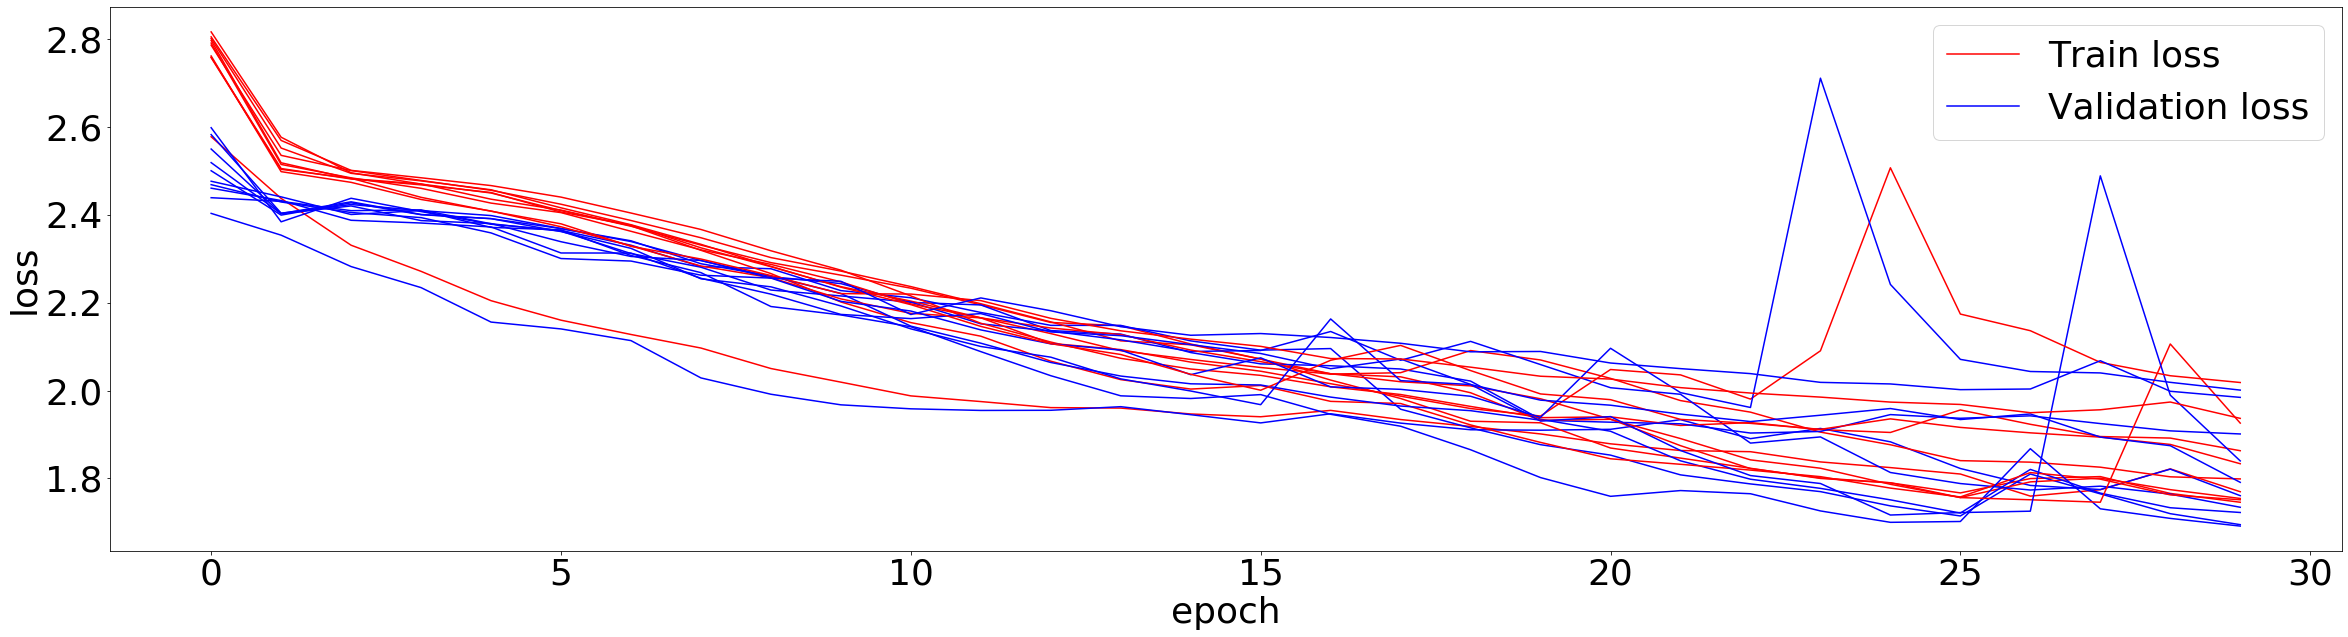

In [23]:
rcParams['figure.figsize'] = 40, 10
rcParams.update({'font.size': 36})
pyplot.figure()
for i, history in enumerate(histories):
    pyplot.plot(history.history['acc'], 'r', label='Train accuracy')
    pyplot.plot(history.history['val_acc'], 'b', label='Validation accuracy')
    if i==0:
        pyplot.legend()
pyplot.xlabel('epoch')
pyplot.ylabel('accuracy')

pyplot.figure()
for i, history in enumerate(histories):
    pyplot.plot(history.history['loss'], 'r', label='Train loss')
    pyplot.plot(history.history['val_loss'], 'b', label='Validation loss')
    if i==0:
        pyplot.legend()
pyplot.xlabel('epoch')
pyplot.ylabel('loss')
rcParams['figure.figsize'] = 20, 10
rcParams.update({'font.size': 24})

# Accuracy

- Overall accuracy
- The top $n$ accuracy; whether the correct answer was in the top $n$ of the model's guesses
- The greedy top $n$ accuracy, whether the correct answer is found if the most occurring class is always guessed first, the second most occurring class second, etc.

In [0]:
# y_test_pred = model.predict([X_char_test, X_word_test, X_user_test])
y_test_pred = ensemble_model.predict([X_char_test])

Accuracy:  46.7 %


(0, 1)

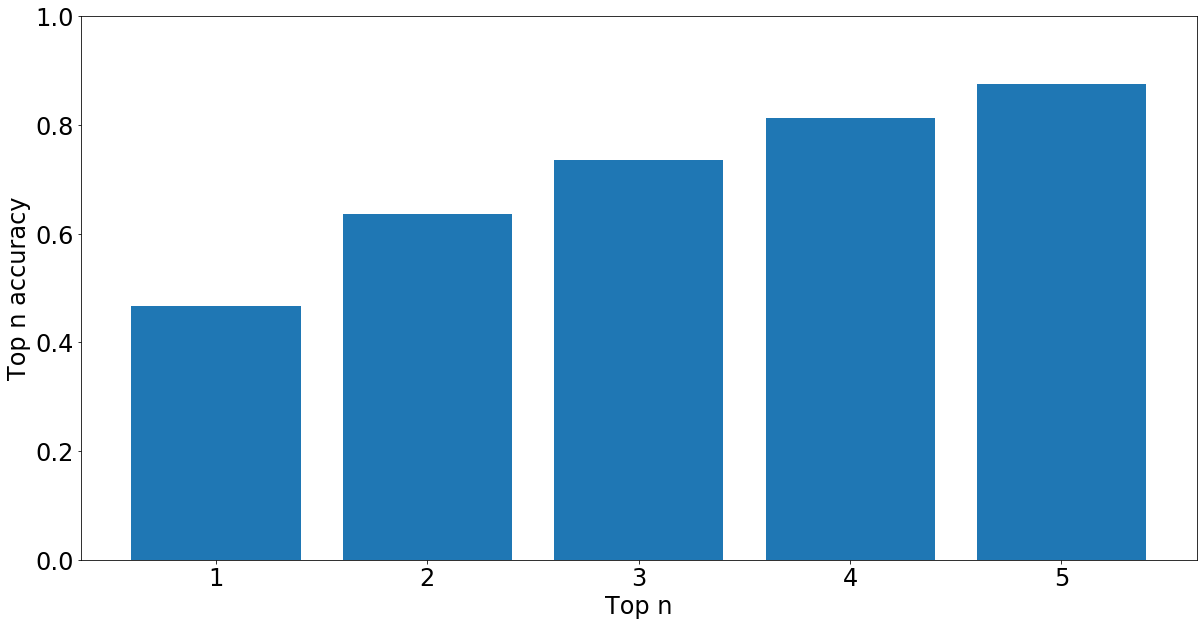

In [25]:
print("Accuracy: ", 100 * (y_test_pred.argmax(1) == y_test).mean(), '%')

accuracy = 0
accuracies = []
y_test_pred_argsort = y_test_pred.argsort(1)
for i in range(y_test_pred.shape[1]):
    accuracy += (y_test_pred_argsort[:, -1-i] == y_test).mean()
    accuracies.append(accuracy)
pyplot.bar(range(1,6), accuracies[:5])
pyplot.xlabel('Top n', FontSize=24)
pyplot.ylabel('Top n accuracy', FontSize=24)
pyplot.ylim(0, 1)

# Confusion matrix

Illustrates the statistics of which actual classes are predicted as which guessed classes. 

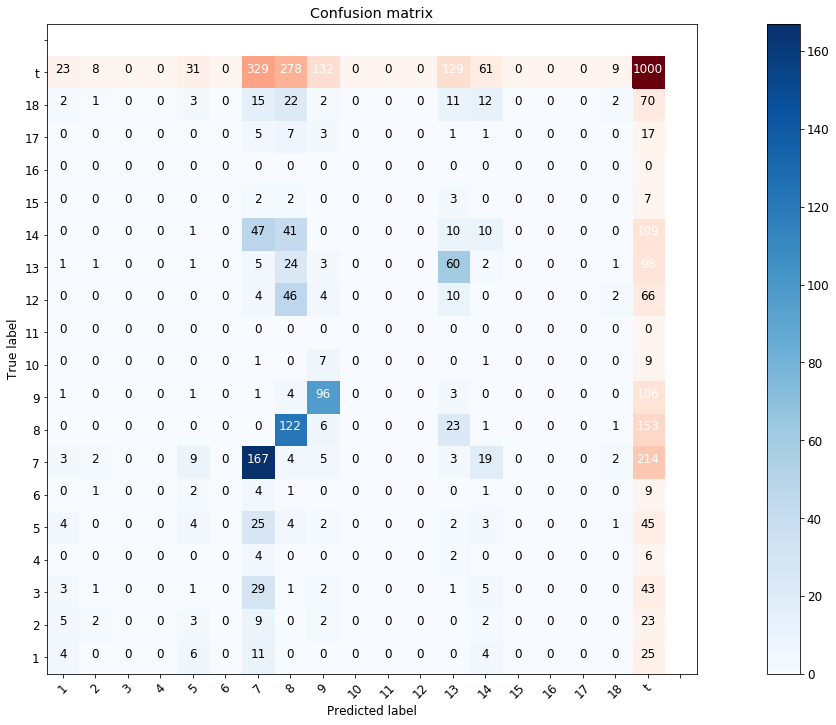

In [26]:
rcParams.update({'font.size': 12})
M = confusion_matrix(y_test + 1,
                     y_test_pred.argmax(1) + 1,
                     labels = numpy.arange(1,19))
clear_output()
pyplot.figure()
plot_confusion_matrix(M, list(range(1, 19)))
rcParams.update({'font.size': 24})

# Recall and precision per class

In [0]:
print(classification_report(y_test + 1, y_test_pred.argmax(1) + 1))

             precision    recall  f1-score   support

          1       0.44      0.32      0.37        25
          2       0.20      0.22      0.21        23
          3       0.00      0.00      0.00        43
          4       0.00      0.00      0.00         6
          5       0.21      0.09      0.12        45
          6       0.00      0.00      0.00         9
          7       0.57      0.73      0.64       214
          8       0.43      0.79      0.56       153
          9       0.74      0.88      0.81       106
         10       0.00      0.00      0.00         9
         12       0.00      0.00      0.00        66
         13       0.49      0.64      0.56        98
         14       0.21      0.24      0.22       109
         15       0.00      0.00      0.00         7
         17       0.00      0.00      0.00        17
         18       0.22      0.03      0.05        70

avg / total       0.38      0.48      0.41      1000



/home/herbert/.virtualenvs/broersma/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Mistakes

For each class, several wrongly predicted tweets.

In [0]:
wrong = data[-n_test:].copy()
wrong['T2_pred'] = y_test_pred.argmax(1) + 1
wrong = wrong[y_test_pred.argmax(1) != y_test].copy() 
wrong = wrong.sample(frac=1)
wrong = wrong.sort_values(['T2', 'T2_pred'])

In [28]:
table = make_table([["id", "actual", "predicted", "Tweet"]] + [
    [tweet["tweet.id"], actual, tweet['T2_pred'],tweet['unshortened_message']]
    for actual in sorted(data[column].unique())
    for _, tweet in wrong[wrong['T2'] == actual].iterrows()
])

start = 1
for actual in sorted(data[column].unique()):
    end = start + len(wrong[wrong['T2'] == actual])
    if actual % 2 == 1:
        for j in range(start, end): set_row_style(j, color='#eee')
    start = end
table

id,actual,predicted,Tweet
477699957147705344,1,5,Bart De Wever weze gewaarschuwd door Het ACW : 'Geen sociale hakbijl' interview P Develtere @tijd https://t.co/6kBeNbzfbjj
477512047828406272,1,5,RT @tijd: Verwilst weg als voorzitter Optima https://t.co/KAnBgHbDFuu
477571885283434497,1,5,"RT @nrcnext: We zijn het wonder van Salvador, wie had dat gedacht? En er nog veel meer moois in next.zaterdag morgen! https://t.co/7pi7s0Pfeff"
477708361023381504,1,5,‘Het westerse model is decadent geworden'. Zeer interessant itw met hoofdredacteur The Economist @tijd https://t.co/FffHxGzkUww
477723346227195904,1,5,Is dit niet hét beeld van gisteravond? Vandaag in NRC. Zo ziet geluk eruit. https://t.co/s0Qz6s1NKjj
477755643827609600,1,5,ELLE Festival kaarten met korting! > http://t.co/1anoghom9o https://t.co/rZXGFnNDphh
477747116262309888,1,7,RT @WouterTorfs: Zin in een scheut positieve nrg? Lees over de 50 grootste durvers in #Tijd. Moest verplichte lectuur op school zijn! #goes…
477700330395041792,1,7,Opmerkelijk opiniestuk van B. Verhaeghe: 'Karel Van Eetvelt danst op het graf van het ondernemerschap' https://t.co/bdMhRpY28yy
477423753534533633,1,7,"Morgen in #dmmagazine Hazard en Lukaku, exclusief voor u! #demorgen https://t.co/FTyDQoVzHjj"
477357835521900544,1,7,Bert van Marwijk beschouwt @nrc elke match van oranje voor. En geeft zijn mening na. https://t.co/gtNb6UOB8VV


# T-SNE

In [0]:
model = models[0]
t_sne_model = Model(model.layers[0].input, model.layers[4].output)

T = t_sne_model.predict(X_char)
tsne = TSNE()

T2 = tsne.fit_transform(T)

In [0]:
for v in set(y):
    pyplot.plot(T2[y==v,0], T2[y==v,1], '.', label='{}'.format(v+1))
pyplot.legend()